# Dean Sayre
# Lecture 12 Homework

### Homework:
### Change the 2-D Godunov's method to second-order accurate in time, using midpoint quantities Wm and Um (follow 1-D example)
### Then run the blast wave solution again and compare the results with the first-order in time results
### to demonstrate that second-order in time is more accurate. 

### this is an implementation of a predict and correct step

### cut through midpoint of the blast wave to check accuracy

In [5]:
# 2-D Godunov scheme with midpoint quantities Wm and Um.
# At the final iteration, I cut through the midpoint of the blast wave for later use.


import numpy as np
import matplotlib.pylab as p
from mpl_toolkits.mplot3d import Axes3D


# 2d grid
L=100.; Nx=100; NGHOST=2; Ny=100
tend=10.1; Dtout=1.

# total number of grids in x and y
Nxg=Nx+2*NGHOST  # Total grid number including ghost zones
Nyg=Ny+2*NGHOST

# look at powerpoint for example of the grid
ist=2           # i direction: active zone starting grid number
ien=Nx+2        # i direction: active zone ending grid number
jst=2           # j direction: active zone starting grid number
jen=Ny+2


NHYDRO=5 # 5 varialbes, rho, mx1, mx2, mx3, E, or rho, vx1, vx2, vx3, pressure
gamma=1.4

# each grid size is one in x and y direction
dx=L/Nx
dy=L/Ny
dareax=dy       # area perpendicular to the x direction
dareay=dx       # area perpendicular to the y direction
dvol=dy*dx      # volume of each grid

Wsave=np.zeros((Nyg,Nxg,int(tend/Dtout)+1,NHYDRO), float)

def main():

    U=np.zeros((Nyg,Nxg,NHYDRO), float)  # conserved variable
    W=np.zeros((Nyg,Nxg,NHYDRO), float)  # primative variable
    Um=np.zeros((Nyg,Nxg,NHYDRO), float)  # conserved variable at mid point - need for HW only?
    Wm=np.zeros((Nyg,Nxg,NHYDRO), float)  # primative variable at mid point - need for HW only?
    Fluxx=np.zeros((Nyg,Nxg,NHYDRO), float)  # flux from the x-direction interface
    Fluxy=np.zeros((Nyg,Nxg,NHYDRO), float)  # flux from the y-direction interface
    fluxa=np.zeros(NHYDRO,float)             # temperal flux for the single interface
    wl=np.zeros(NHYDRO, float)          # left state
    wr=np.zeros(NHYDRO, float)          # right state

    # setup the problem
    prob2(U,W)
    Um[:]=U[:]
    Wm[:]=W[:]

    toutn=0
    t=0.
    while t < tend:
        # time step, minimum dt of all grids
        dt=0.4*np.min(np.min([dx,dy])/(np.sqrt(W[jst:jen,ist:ien,1]*W[jst:jen,ist:ien,1]+W[jst:jen,ist:ien,2]*W[jst:jen,ist:ien,2]+W[jst:jen,ist:ien,3]*W[jst:jen,ist:ien,3])+np.sqrt(gamma*W[jst:jen,ist:ien,4]/W[jst:jen,ist:ien,0])))
        # calculate x interface flux
        for j in np.arange(jst, jen+1): # this is an x sweep for each y
            for i in np.arange(ist, ien+1):
                reconst(W, wl, wr, i, j, dx, dy, 1) # construct left and right states
                rsolver(wl,wr,fluxa,1) # solve flux at l/r interfaces
                Fluxx[j,i,:]=fluxa[:]
        # calculate y interface flux
        for i in np.arange(ist, ien+1): # this is a y sweep for each x
            for j in np.arange(jst, jen+1):
                reconst(W, wl, wr, i, j, dx, dy, 2)
                rsolver(wl,wr,fluxa,2)
                Fluxy[j,i,:]=fluxa[:]
        # calculate the midpoint quatinties first 
        for j in np.arange(jst,jen):
            for i in np.arange(ist, ien):
                for idex in range(NHYDRO):
                    Um[j,i,idex]=(U[j,i,idex] + (Fluxx[j,i,idex]-Fluxx[j,i+1,idex])*dt*0.5*dareax/dvol
                                +(Fluxy[j,i,idex]-Fluxy[j+1,i,idex])*dt*0.5*dareay/dvol) # finish this line to update quantities in a grid

        # conservative varialbe to primitive midpoint variable
        contoprim(Um, Wm)
        # update the primitive midpoint variable at the boundary
        boundary(Wm)

        # resconstruct again

        for j in np.arange(jst, jen+1): # this is an x sweep for each y
            for i in np.arange(ist, ien+1):
                reconst(Wm, wl, wr, i, j, dx, dy, 1) # construct left and right states
                rsolver(wl,wr,fluxa,1) # solve flux at l/r interfaces
                Fluxx[j,i,:]=fluxa[:]
        # calculate y interface flux
        for i in np.arange(ist, ien+1): # this is a y sweep for each x
            for j in np.arange(jst, jen+1):
                reconst(Wm, wl, wr, i, j, dx, dy, 2)
                rsolver(wl,wr,fluxa,2)
                Fluxy[j,i,:]=fluxa[:]
        
        # update U and W
        for j in np.arange(jst,jen):
                    for i in np.arange(ist, ien):
                        for idex in range(NHYDRO):
                            U[j,i,idex]=(U[j,i,idex] + (Fluxx[j,i,idex]-Fluxx[j,i+1,idex])*dt*0.5*dareax/dvol
                                        +(Fluxy[j,i,idex]-Fluxy[j+1,i,idex])*dt*0.5*dareay/dvol) # finish this line to update quantities in a grid

        contoprim(U, W)
        boundary(W)

        if t >= toutn*Dtout:
            print(toutn)
            x = list(range(0, Nxg))                       # Plot alternate pts
            y = list(range(0, Nyg))
            X, Y = p.meshgrid(x, y)
            Z = W[Y,X,0]                                  # plot 0: density,...
            levels=p.arange(np.min(Z)*0.8,np.max(Z)*1.2,(np.max(Z)*1.2 - np.min(Z)*0.8)/256.)
            CS=p.contour(x,y,Z,levels)
            p.xlabel('X')
            p.ylabel('Y')
            p.colorbar(CS)
            p.show()
            toutn += 1

        
        t+=dt
        print(dt)
    
    print("finished")
    p.title('Cut W/ Midpoint Quantities')
    p.xlabel('x')
    p.ylabel('Z')
    p.plot(x,Z)
    p.show()



# Sod shock tube in the x direction
def prob1(U,W):
    for j in range(Nyg):
        for i in range(int(Nxg/2)):
            U[j,i,0]=8.
            W[j,i,0]=8.
            W[j,i,4]=10./gamma
            U[j,i,4]=W[j,i,4]/(gamma-1)
        for i in range(int(Nxg/2), Nxg):
            U[j,i,0]=1.
            W[j,i,0]=1.
            W[j,i,4]=1.0/gamma
            U[j,i,4]=W[j,i,4]/(gamma-1)
    boundary(W)

# blast wave solution
def prob2(U,W):
    for j in range(Nyg):
        for i in range(Nxg):
            #propogates the region with low or high density, depending on the if else.
            if (i-Nxg/2.)*(i-Nxg/2)+(j-Nyg/2.)*(j-Nyg/2)<100.0:
                U[j,i,0]=1.
                W[j,i,0]=1.
                W[j,i,4]=1.0/gamma
                U[j,i,4]=W[j,i,4]/(gamma-1)
            else:
                U[j,i,0]=0.1
                W[j,i,0]=0.1
                W[j,i,4]=0.1/gamma
                U[j,i,4]=W[j,i,4]/(gamma-1)
    boundary(W)



# reconstruction
def reconst(W, wl, wr, i, j, dlx, dly, dire):
    reconst_plm(W, wl, wr, i, j, dlx, dly, dire)

# donor cell reconstruction
def reconst_donor(W, wl, wr, i, j, dlx, dly, dire):
    if dire==1:
        for idex in range(NHYDRO):
            wl[idex]=W[j,i-1,idex]
            wr[idex]=W[j,i,idex]
    if dire==2:
        for idex in range(NHYDRO):
            wl[idex]=W[j-1,i,idex]
            wr[idex]=W[j,i,idex]


# piecewise linear reconstruction
def reconst_plm(W, wl, wr, i, j, dlx, dly, dire):
    for idex in range(NHYDRO):
        if dire==1:
            wm1=W[j,i-1,idex]
            wm2=W[j,i-2,idex]
            w=W[j,i,idex]
            wp1=W[j,i+1,idex]
            dl=dlx
        if dire==2:
            wm1=W[j-1,i,idex]
            wm2=W[j-2,i,idex]
            w=W[j,i,idex]
            wp1=W[j+1,i,idex]
            dl=dly
        dql=(wm1-wm2)/dl
        dqc=(w-wm1)/dl
        dqr=(wp1-w)/dl

        dq2=dql*dqc
        if (dq2>0.0):
            dqm=dq2/(dql+dqc)
        else:
            dqm=0.0

        wl[idex]=wm1+dqm*dl

        dq2=dqc*dqr
        if(dq2>0.0):
            dqm=dq2/(dqc+dqr)
        else:
            dqm=0.0

        wr[idex]=w-dqm*dl

# hlle Reimann solver
def rsolver(wl,wr,fluxa,dire):
    # Compute Roe-averaged state
    if dire==1:
        ivx=1
        ivy=2
    if dire==2:
        ivx=2
        ivy=1
    sqrtdl = np.sqrt(wl[0])
    sqrtdr = np.sqrt(wr[0])
    isdlpdr = 1./(sqrtdl+sqrtdr)

    roed=sqrtdl*sqrtdr
    roevx=(sqrtdl*wl[ivx]+sqrtdr*wr[ivx])*isdlpdr
    roevy=(sqrtdl*wl[ivy]+sqrtdr*wr[ivy])*isdlpdr
    roevz=(sqrtdl*wl[3]+sqrtdr*wr[3])*isdlpdr
        #The enthalpy H=(E+P)/d is averaged sqrtdl*hl = sqrtdl*(el+pl)/dl = (el+pl)/sqrtdl
    el = wl[4]/(gamma-1.)+0.5*wl[0]*(wl[ivx]*wl[ivx]+wl[ivy]*wl[ivy]+wl[3]*wl[3])
    er = wr[4]/(gamma-1.)+0.5*wr[0]*(wr[ivx]*wr[ivx]+wr[ivy]*wr[ivy]+wr[3]*wr[3])
    roeh = ((el+wl[4])/sqrtdl+(er+wr[4])/sqrtdr)*isdlpdr

    # Compute sound speed in L,R, and Roe-averaged state
    cl=np.sqrt(gamma*wl[4]/wl[0])
    cr=np.sqrt(gamma*wr[4]/wr[0])
    q=roeh-0.5*(roevx*roevx+roevy*roevy+roevz*roevz)
    if(q<0.0):
        q=0.0
    a=np.sqrt((gamma-1.)*q)

    # Compute the max/min wave speeds based on L/R and Roe-averaged values
    al=min([roevx-a,wl[ivx]-cl])
    ar=max([roevx+a,wr[ivx]+cr])
    if ar>0.0:
        bp=ar
    else:
        bp=0.0
    if al<0.0:
        bm=al
    else:
        bm=0.0

    #Compute L/R fluxes along the lines bm/bp: F_L - (S_L)U_L; F_R - (S_R)U_R
    fl=np.zeros(NHYDRO, float)
    fr=np.zeros(NHYDRO, float)

    fl[0]=wl[0]*wl[ivx]-bm*wl[0]
    fr[0]=wr[0]*wr[ivx]-bp*wr[0]
    fl[ivx]=wl[0]*wl[ivx]*(wl[ivx]-bm)
    fr[ivx]=wr[0]*wr[ivx]*(wr[ivx]-bp)
    fl[ivy]=wl[0]*wl[ivy]*(wl[ivx]-bm)
    fr[ivy]=wr[0]*wr[ivy]*(wr[ivx]-bp)
    fl[3]=wl[0]*wl[3]*(wl[ivx]-bm)
    fr[3]=wr[0]*wr[3]*(wr[ivx]-bp)
    fl[ivx] += wl[4]
    fr[ivx] += wr[4]
    fl[4] = el*(wl[ivx]-bm)+wl[4]*wl[ivx]
    fr[4] = er*(wr[ivx]-bp)+wr[4]*wr[ivx]

    if (bp==bm):
        tmp = 0.0
    else:
        tmp = 0.5*(bp+bm)/(bp-bm)

    fluxa[0]=0.5*(fl[0]+fr[0])+(fl[0]-fr[0])*tmp
    fluxa[ivx]=0.5*(fl[ivx]+fr[ivx])+(fl[ivx]-fr[ivx])*tmp
    fluxa[ivy]=0.5*(fl[ivy]+fr[ivy])+(fl[ivy]-fr[ivy])*tmp
    fluxa[3]=0.5*(fl[3]+fr[3])+(fl[3]-fr[3])*tmp
    fluxa[4]=0.5*(fl[4]+fr[4])+(fl[4]-fr[4])*tmp

# conservative variables to primitive variables
def contoprim(U, W):
    for j in np.arange(jst,jen):
            for i in np.arange(ist, ien):
                W[j,i,0]=max([U[j,i,0],1.e-30]) # to add stability for the Reimann solver, make sure density and pressure are positive
                W[j,i,1]=U[j,i,1]/W[j,i,0]
                W[j,i,2]=U[j,i,2]/W[j,i,0]
                W[j,i,3]=U[j,i,3]/W[j,i,0]
                W[j,i,4]=max([(U[j,i,4]-0.5*W[j,i,0]*(W[j,i,1]**2+W[j,i,2]**2+W[j,i,3]**2))*(gamma-1),1.e-30])

# primitive variables to conservative variables
def primtocon(W,U):
    for j in np.arange(jst,jen):
            for i in np.arange(ist, ien):
                U[j,i,0]=W[j,i,0]
                U[j,i,1]=W[j,i,1]*W[j,i,0]
                U[j,i,2]=W[j,i,2]*W[j,i,0]
                U[j,i,3]=W[j,i,3]*W[j,i,0]
                U[j,i,4]=0.5*W[j,i,0]*(W[j,i,1]**2+W[j,i,2]**2+W[j,i,3]**2)+W[j,i,4]/(gamma-1)

# boundary condition
def boundary(W):
    periodic(W)

# periodic boundary
def periodic(W):
    for j in np.arange(jst,jen):
        for idex in range(NHYDRO):
            W[j,0,idex]=W[j,Nxg-4,idex]
            W[j,1,idex]=W[j,Nxg-3,idex]
            W[j,Nxg-2,idex]=W[j,2,idex]
            W[j,Nxg-1,idex]=W[j,3,idex]

    for i in np.arange(0,Nxg):
        for idex in range(NHYDRO):
            W[0,i,idex]=W[Nyg-4,i,idex]
            W[1,i,idex]=W[Nyg-3,i,idex]
            W[Nyg-2,i,idex]=W[2,i,idex]
            W[Nyg-1,i,idex]=W[3,i,idex]

# outflow boundary
def outflow(W):
    for j in np.arange(jst,jen):
        for idex in range(NHYDRO):
            W[j,0,idex]=W[j,2,idex]
            W[j,1,idex]=W[j,2,idex]
            W[j,Nxg-2,idex]=W[j,Nxg-3,idex]
            W[j,Nxg-1,idex]=W[j,Nxg-3,idex]

    for i in np.arange(0,Nxg):
        for idex in range(NHYDRO):
            W[0,i,idex]=W[2,i,idex]
            W[1,i,idex]=W[2,i,idex]
            W[Nyg-2,i,idex]=W[Nyg-3,i,idex]
            W[Nyg-1,i,idex]=W[Nyg-3,i,idex]

0


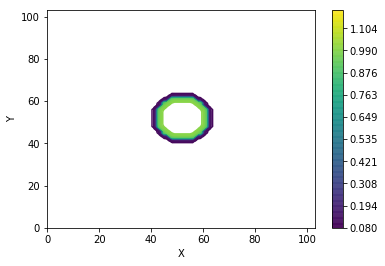

0.4
0.27033665771932175
0.25815707599817656
0.252032446653077
1


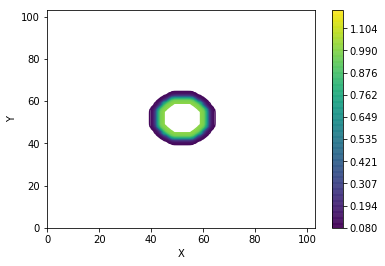

0.2483065666101752
0.24410231112690398
0.24104596173228102
0.23720475378159672
2


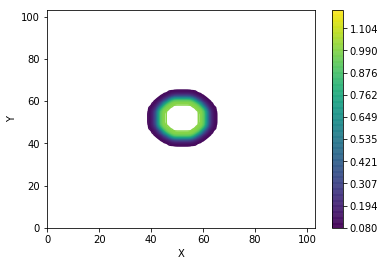

0.2330413187845337
0.23016277515006023
0.22828631417105136
0.227080286018428
3


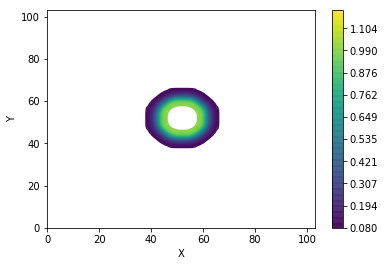

0.2255835737309332
0.2241762523316569
0.2232831447703872
0.2226405719898303
0.2208821870016344
4


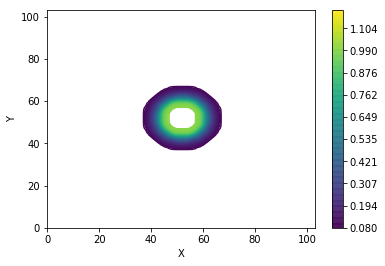

0.21901428752092353
0.21785905346852807
0.21732940389794148
0.21707186008320806
5


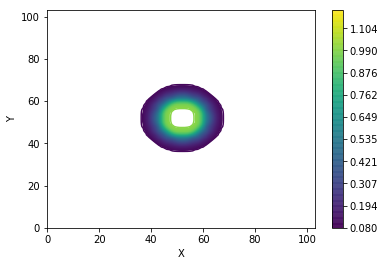

0.21720557890550976
0.21771466965265876
0.21733504748446564
0.21533430146506266
0.21398744607283474
6


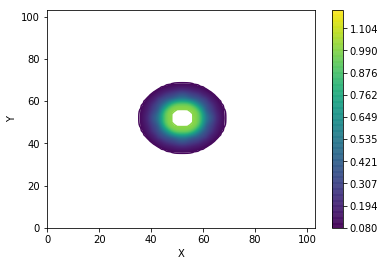

0.21317231277872697
0.21278537797665864
0.2127462631313821
0.21299134772706935
0.21296207507206374
7


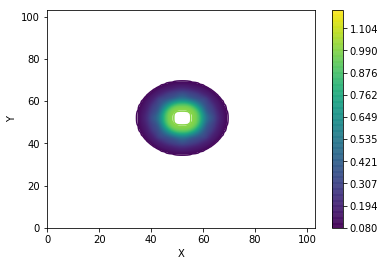

0.21156601436566544
0.21068259795422267
0.2102179194421684
0.21009872382141237
8


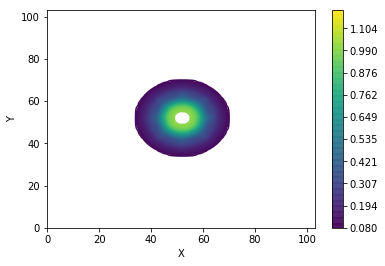

0.21026696532242783
0.2106764176420319
0.2112893909114594
0.2108439674566701
0.21029207390130816
9


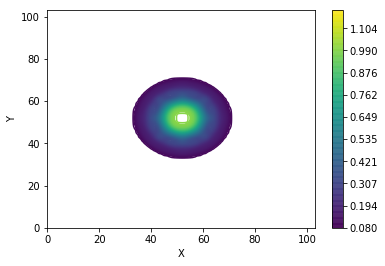

0.21008919071465956
0.21015171056103796
0.21043823127231068
0.21083390064839116
0.21132581388420868
finished


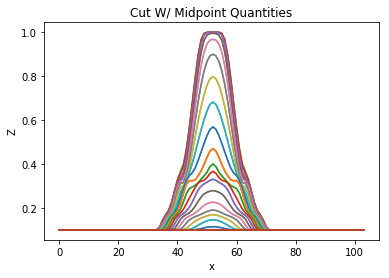

In [6]:
main()

In [11]:
# 2-D Godunov scheme

import numpy as np
import matplotlib.pylab as p
from mpl_toolkits.mplot3d import Axes3D 


# 2d grid
L=100.; Nx=100; NGHOST=2; Ny=100
tend=10.1; Dtout=1.

# total number of grids in x and y
Nxg=Nx+2*NGHOST  # Total grid number including ghost zones
Nyg=Ny+2*NGHOST

# look at powerpoint for example of the grid 
ist=2           # i direction: active zone starting grid number
ien=Nx+2        # i direction: active zone ending grid number
jst=2           # j direction: active zone starting grid number
jen=Ny+2


NHYDRO=5 # 5 varialbes, rho, mx1, mx2, mx3, E, or rho, vx1, vx2, vx3, pressure
gamma=1.4

# each grid size is one in x and y direction
dx=L/Nx
dy=L/Ny
dareax=dy       # area perpendicular to the x direction
dareay=dx       # area perpendicular to the y direction
dvol=dy*dx      # volume of each grid

Wsave=np.zeros((Nyg,Nxg,int(tend/Dtout)+1,NHYDRO), float)

def main():

    U=np.zeros((Nyg,Nxg,NHYDRO), float)  # conserved variable
    W=np.zeros((Nyg,Nxg,NHYDRO), float)  # primative variable
    Um=np.zeros((Nyg,Nxg,NHYDRO), float)  # conserved variable at mid point - need for HW only? 
    Wm=np.zeros((Nyg,Nxg,NHYDRO), float)  # primative variable at mid point - need for HW only?
    Fluxx=np.zeros((Nyg,Nxg,NHYDRO), float)  # flux from the x-direction interface
    Fluxy=np.zeros((Nyg,Nxg,NHYDRO), float)  # flux from the y-direction interface
    fluxa=np.zeros(NHYDRO,float)             # temperal flux for the single interface
    wl=np.zeros(NHYDRO, float)          # left state
    wr=np.zeros(NHYDRO, float)          # right state

    # setup the problem
    prob2(U,W)
    Um[:]=U[:]
    Wm[:]=W[:]

    toutn=0
    t=0.
    while t < tend:   
        # time step, minimum dt of all grids
        dt=0.5*np.min(np.min([dx,dy])/(np.sqrt(W[jst:jen,ist:ien,1]*W[jst:jen,ist:ien,1]+W[jst:jen,ist:ien,2]*W[jst:jen,ist:ien,2]+W[jst:jen,ist:ien,3]*W[jst:jen,ist:ien,3])+np.sqrt(gamma*W[jst:jen,ist:ien,4]/W[jst:jen,ist:ien,0])))
        # calculate x interface flux
        for j in np.arange(jst, jen+1): # this is an x sweep for each y  
            for i in np.arange(ist, ien+1):                       
                reconst(W, wl, wr, i, j, dx, dy, 1) # construct left and right states   
                rsolver(wl,wr,fluxa,1) # solve flux at l/r interfaces
                Fluxx[j,i,:]=fluxa[:] 
        # calculate y interface flux
        for i in np.arange(ist, ien+1): # this is a y sweep for each x
            for j in np.arange(jst, jen+1):
                reconst(W, wl, wr, i, j, dx, dy, 2)
                rsolver(wl,wr,fluxa,2)
                Fluxy[j,i,:]=fluxa[:]
        # update all the active zone
        for j in np.arange(jst,jen):
            for i in np.arange(ist, ien): 
                for idex in range(NHYDRO):
                    U[j,i,idex]=(U[j,i,idex] + (Fluxx[j,i,idex]-Fluxx[j,i+1,idex])*dt*dareax/dvol
                                +(Fluxy[j,i,idex]-Fluxy[j+1,i,idex])*dt*dareay/dvol) # finish this line to update quantities in a grid
                    
        # conservative varialbe to primitive variable
        contoprim(U, W)
        # update the primitive variable at the boundary
        boundary(W)

        
        if t >= toutn*Dtout: 
            #print(toutn)   
            x = list(range(0, Nxg))                       # Plot alternate pts
            y = list(range(0, Nyg))                      
            X, Y = p.meshgrid(x, y)                       
            Z = W[Y,X,0]                                  # plot 0: density,...
            #levels=p.arange(np.min(Z)*0.8,np.max(Z)*1.2,(np.max(Z)*1.2 - np.min(Z)*0.8)/256.)
            #CS=p.contour(x,y,Z,levels)
            #p.xlabel('X')
            #p.ylabel('Y')
            #p.colorbar(CS)
            #p.show()  
            toutn += 1    
         
            
        t+=dt
        #print(dt)
    
    print("finished")
    p.title('Cut W/O Midpoint Quantities')
    p.xlabel('x')
    p.ylabel('Z')
    p.plot(x,Z)
    p.show()

    

# Sod shock tube in the x direction    
def prob1(U,W):
    for j in range(Nyg):
        for i in range(int(Nxg/2)):
            U[j,i,0]=8.
            W[j,i,0]=8.
            W[j,i,4]=10./gamma
            U[j,i,4]=W[j,i,4]/(gamma-1) 
        for i in range(int(Nxg/2), Nxg):
            U[j,i,0]=1.
            W[j,i,0]=1.
            W[j,i,4]=1.0/gamma
            U[j,i,4]=W[j,i,4]/(gamma-1) 
    boundary(W)

# blast wave solution  
def prob2(U,W):
    for j in range(Nyg):
        for i in range(Nxg):
            #propogates the region with low or high density, depending on the if else.
            if (i-Nxg/2.)*(i-Nxg/2)+(j-Nyg/2.)*(j-Nyg/2)<100.0:
                U[j,i,0]=1.
                W[j,i,0]=1.
                W[j,i,4]=1.0/gamma
                U[j,i,4]=W[j,i,4]/(gamma-1) 
            else:
                U[j,i,0]=0.1
                W[j,i,0]=0.1
                W[j,i,4]=0.1/gamma
                U[j,i,4]=W[j,i,4]/(gamma-1) 
    boundary(W)


    
# reconstruction
def reconst(W, wl, wr, i, j, dlx, dly, dire):
    reconst_plm(W, wl, wr, i, j, dlx, dly, dire)
    
# donor cell reconstruction
def reconst_donor(W, wl, wr, i, j, dlx, dly, dire):
    if dire==1:
        for idex in range(NHYDRO):
            wl[idex]=W[j,i-1,idex]
            wr[idex]=W[j,i,idex]
    if dire==2:
        for idex in range(NHYDRO):
            wl[idex]=W[j-1,i,idex]
            wr[idex]=W[j,i,idex]
            
        
# piecewise linear reconstruction
def reconst_plm(W, wl, wr, i, j, dlx, dly, dire):
    for idex in range(NHYDRO):
        if dire==1:
            wm1=W[j,i-1,idex]
            wm2=W[j,i-2,idex]
            w=W[j,i,idex]
            wp1=W[j,i+1,idex]
            dl=dlx
        if dire==2:
            wm1=W[j-1,i,idex]
            wm2=W[j-2,i,idex]
            w=W[j,i,idex]
            wp1=W[j+1,i,idex]
            dl=dly
        dql=(wm1-wm2)/dl
        dqc=(w-wm1)/dl
        dqr=(wp1-w)/dl
        
        dq2=dql*dqc
        if (dq2>0.0):
            dqm=dq2/(dql+dqc)
        else:
            dqm=0.0
            
        wl[idex]=wm1+dqm*dl

        dq2=dqc*dqr
        if(dq2>0.0):
            dqm=dq2/(dqc+dqr)
        else:
            dqm=0.0
        
        wr[idex]=w-dqm*dl

# hlle Reimann solver
def rsolver(wl,wr,fluxa,dire):
    # Compute Roe-averaged state
    if dire==1:
        ivx=1
        ivy=2
    if dire==2:
        ivx=2
        ivy=1
    sqrtdl = np.sqrt(wl[0])   
    sqrtdr = np.sqrt(wr[0])
    isdlpdr = 1./(sqrtdl+sqrtdr)
    
    roed=sqrtdl*sqrtdr
    roevx=(sqrtdl*wl[ivx]+sqrtdr*wr[ivx])*isdlpdr
    roevy=(sqrtdl*wl[ivy]+sqrtdr*wr[ivy])*isdlpdr
    roevz=(sqrtdl*wl[3]+sqrtdr*wr[3])*isdlpdr
        #The enthalpy H=(E+P)/d is averaged sqrtdl*hl = sqrtdl*(el+pl)/dl = (el+pl)/sqrtdl
    el = wl[4]/(gamma-1.)+0.5*wl[0]*(wl[ivx]*wl[ivx]+wl[ivy]*wl[ivy]+wl[3]*wl[3])
    er = wr[4]/(gamma-1.)+0.5*wr[0]*(wr[ivx]*wr[ivx]+wr[ivy]*wr[ivy]+wr[3]*wr[3])
    roeh = ((el+wl[4])/sqrtdl+(er+wr[4])/sqrtdr)*isdlpdr
    
    # Compute sound speed in L,R, and Roe-averaged state
    cl=np.sqrt(gamma*wl[4]/wl[0])
    cr=np.sqrt(gamma*wr[4]/wr[0])
    q=roeh-0.5*(roevx*roevx+roevy*roevy+roevz*roevz)
    if(q<0.0):
        q=0.0
    a=np.sqrt((gamma-1.)*q)

    # Compute the max/min wave speeds based on L/R and Roe-averaged values
    al=min([roevx-a,wl[ivx]-cl])
    ar=max([roevx+a,wr[ivx]+cr])
    if ar>0.0:
        bp=ar
    else:
        bp=0.0
    if al<0.0:
        bm=al
    else:
        bm=0.0
        
    #Compute L/R fluxes along the lines bm/bp: F_L - (S_L)U_L; F_R - (S_R)U_R
    fl=np.zeros(NHYDRO, float)
    fr=np.zeros(NHYDRO, float)
    
    fl[0]=wl[0]*wl[ivx]-bm*wl[0]
    fr[0]=wr[0]*wr[ivx]-bp*wr[0]
    fl[ivx]=wl[0]*wl[ivx]*(wl[ivx]-bm)
    fr[ivx]=wr[0]*wr[ivx]*(wr[ivx]-bp)
    fl[ivy]=wl[0]*wl[ivy]*(wl[ivx]-bm)
    fr[ivy]=wr[0]*wr[ivy]*(wr[ivx]-bp)
    fl[3]=wl[0]*wl[3]*(wl[ivx]-bm)
    fr[3]=wr[0]*wr[3]*(wr[ivx]-bp)
    fl[ivx] += wl[4]
    fr[ivx] += wr[4]
    fl[4] = el*(wl[ivx]-bm)+wl[4]*wl[ivx]
    fr[4] = er*(wr[ivx]-bp)+wr[4]*wr[ivx]
    
    if (bp==bm):
        tmp = 0.0
    else:
        tmp = 0.5*(bp+bm)/(bp-bm)
        
    fluxa[0]=0.5*(fl[0]+fr[0])+(fl[0]-fr[0])*tmp
    fluxa[ivx]=0.5*(fl[ivx]+fr[ivx])+(fl[ivx]-fr[ivx])*tmp
    fluxa[ivy]=0.5*(fl[ivy]+fr[ivy])+(fl[ivy]-fr[ivy])*tmp
    fluxa[3]=0.5*(fl[3]+fr[3])+(fl[3]-fr[3])*tmp
    fluxa[4]=0.5*(fl[4]+fr[4])+(fl[4]-fr[4])*tmp
    
# conservative variables to primitive variables
def contoprim(U, W):
    for j in np.arange(jst,jen):
            for i in np.arange(ist, ien):
                W[j,i,0]=max([U[j,i,0],1.e-30]) # to add stability for the Reimann solver, make sure density and pressure are positive
                W[j,i,1]=U[j,i,1]/W[j,i,0]
                W[j,i,2]=U[j,i,2]/W[j,i,0]
                W[j,i,3]=U[j,i,3]/W[j,i,0]
                W[j,i,4]=max([(U[j,i,4]-0.5*W[j,i,0]*(W[j,i,1]**2+W[j,i,2]**2+W[j,i,3]**2))*(gamma-1),1.e-30])
    
# primitive variables to conservative variables   
def primtocon(W,U):
    for j in np.arange(jst,jen):
            for i in np.arange(ist, ien):
                U[j,i,0]=W[j,i,0]
                U[j,i,1]=W[j,i,1]*W[j,i,0]
                U[j,i,2]=W[j,i,2]*W[j,i,0]
                U[j,i,3]=W[j,i,3]*W[j,i,0]
                U[j,i,4]=0.5*W[j,i,0]*(W[j,i,1]**2+W[j,i,2]**2+W[j,i,3]**2)+W[j,i,4]/(gamma-1)

# boundary condition
def boundary(W):    
    periodic(W)
    
# periodic boundary
def periodic(W):
    for j in np.arange(jst,jen):
        for idex in range(NHYDRO):
            W[j,0,idex]=W[j,Nxg-4,idex]
            W[j,1,idex]=W[j,Nxg-3,idex]
            W[j,Nxg-2,idex]=W[j,2,idex]
            W[j,Nxg-1,idex]=W[j,3,idex]
                
    for i in np.arange(0,Nxg):
        for idex in range(NHYDRO):
            W[0,i,idex]=W[Nyg-4,i,idex]
            W[1,i,idex]=W[Nyg-3,i,idex]
            W[Nyg-2,i,idex]=W[2,i,idex]
            W[Nyg-1,i,idex]=W[3,i,idex]
    
# outflow boundary
def outflow(W):
    for j in np.arange(jst,jen):
        for idex in range(NHYDRO):
            W[j,0,idex]=W[j,2,idex]
            W[j,1,idex]=W[j,2,idex]
            W[j,Nxg-2,idex]=W[j,Nxg-3,idex]
            W[j,Nxg-1,idex]=W[j,Nxg-3,idex]
                
    for i in np.arange(0,Nxg):
        for idex in range(NHYDRO):
            W[0,i,idex]=W[2,i,idex]
            W[1,i,idex]=W[2,i,idex]
            W[Nyg-2,i,idex]=W[Nyg-3,i,idex]
            W[Nyg-1,i,idex]=W[Nyg-3,i,idex]

finished


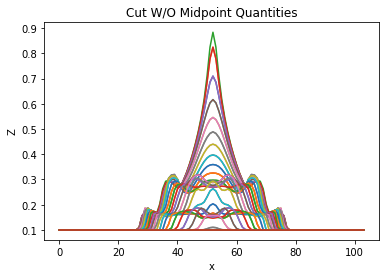

In [12]:
main()

### Comparing the two cuts from the different methods, it can be seen that implementing the 2-D Godunov's method with midpoint quantities leads to second order accuracy in time. Furthermore, less oscillations can be seen with midpoint quantities.